# PureFacts Programming Challenge Problem Response

- **By**: Jeffrey Zhou
- **Date**: November 5th 2022

## A quick abstract:
In this project, which I completed during the 2022 PureFacts Programming Challenge, I was asked to take a two-dimensional dataset of points on the Cartesian plane and find the $N$ points that would best "cover" the shape that is created when the points in the dataset are graphed. These values of $N$ were $10, 25, 63, 159,$ and $380$.

To do this, I employed an approach that synthesizes the $K$-Means Clustering algorithm and the $K$-Nearest Neighbours decision algorithm. For each value of $N$, I performed a $K$-Means Clustering on the dataset where I set $K = N$ in order to find a "centroid" that would represent each of the clusters. However, simply taking each of the centroids to be the points obviously won't always work because the centroids won't necessarily be in the dataset itself, and this is where things get interesting.

I found that in order to find the points that best "cover" the *shape* of the points and not the density, I couldn't just take the point in the cluster represented by the centroid that is closest to the centroid. Rather, I needed to strike a balance between this "closest" point and the point that is in the cluster that is furthest from the centroid, since the nature of the $K$-Means algorithm will skew the centroid closer to the area where the points are more dense, and if I wanted to find the point in each cluster that helps to best "cover" the *shape* of the overall data, I couldn't just flat-out ignore the "furthest" points.

Thus, after finding the centroids, I found the points in each of the centroids' respective clusters that were the closest and the furthest away from the centroids with respect to Euclidean distance. That is, given a centroid $C = (x_c, y_c)$ and an arbitrary point $v = (x_0, y_0)$, the distance between these 2 points is $$\sqrt{(x_c - x_0)^2 + (y_c - y_0)^2}$$


Using the closest and furthest points (call them $v_{closest} = (x_{closest}, y_{closest})$ and $v_{furthest} = (x_{furthest}, y_{furthest})$), I found their average using the formula $$v_{average} = (\frac{x_{closest} + x_{furthest}}{2}, \frac{x_{furthest} + y_{furthest}}{2})$$

Then, as a final step, I used the $K$-Nearest Neighbours algorithm (with $K = 1$) to find the point in the cluster closest to the average calculated above. By taking these points in the $N$ clusters as the $N$ points that would be used to "cover" the shape of the data, I minimize the impact of the density of the points in any of the clusters, which is a problem that would have caused major headaches if I had simply taken the points in the clusters closest to the centroids as the $N$ points to "cover" the shape of the data instead.

### Import the necessary data and libraries

In [303]:
from typing import List, Any
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from google.colab import files
%matplotlib inline

In [286]:
input = pd.read_csv('https://raw.githubusercontent.com/jeffreyz374/cssu-purefacts-fall-2022-jeffrey-zhou/main/input.csv')
input.loc[999] = [3825, 5286] # During import, the first coordinate point (3825, 5286) was deleted, so this step just adds it into the dataset manually
input.columns = ['x', 'y']

### Plot the data to get a visualization of the shape



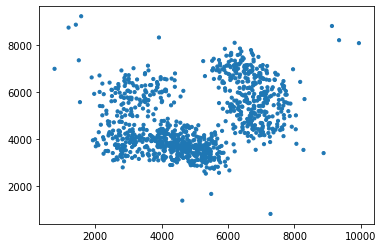

In [287]:
sizes = [10] * len(input)
plt.scatter(input['x'], input['y'], sizes)
plt.show()

### Write some helper functions

In [288]:
def find_closest_points(centroids: List[List[int]], labels: List[int]) -> List[List[int]]:
  """ Each of the points in the input dataset belongs to a cluster computed by the
  K-Means algorithm and are labelled according to their cluster in labels. This
  function finds the point in each of the clusters closest to the respective centroid
  in centroids. For example, every entry in labels that has value 0 corresponds
  to a point in inputs that is part of cluster 0 with calculated centroid centroids[0]
  """
  closest_points = []
  for i in range(len(centroids)):
    closest = [None, None] # [Min Distance so far, corresponding point]
    for j in range(len(input)):
      if labels[j] == i:
        calculated_distance = np.sqrt((centroids[i][0] - input['x'][j]) ** 2 + (centroids[i][1] - input['y'][j]) ** 2)
        if closest[0] is None or (closest[0] is not None and calculated_distance < closest[0]):
          closest[0] = calculated_distance
          closest[1] = list(input.iloc[j])
    closest_points.append(closest[1])

  return closest_points

def find_farthest_points(centroids: List[List[int]], labels: List[int]) -> List[List[int]]:
  """ Each of the points in the input dataset belongs to a cluster computed by the
  K-Means algorithm and are labelled according to their cluster in labels. This
  function finds the point in each of the clusters FARTHEST to the respective centroid
  in centroids. For example, every entry in labels that has value 0 corresponds
  to a point in inputs that is part of cluster 0 with calculated centroid centroids[0]
  """
  farthest_points = []
  for i in range(len(centroids)):
    farthest = [None, None] # [Max Distance so far, corresponding point]
    for j in range(len(input)):
      if labels[j] == i:
        calculated_distance = np.sqrt((centroids[i][0] - input['x'][j]) ** 2 + (centroids[i][1] - input['y'][j]) ** 2)
        if farthest[0] is None or (farthest[0] is not None and calculated_distance > farthest[0]):
          farthest[0] = calculated_distance
          farthest[1] = list(input.iloc[j])
    farthest_points.append(farthest[1]) 

  return farthest_points

def find_average_point(closest_points: List[List[int]], farthest_points: List[List[int]]) -> List[List[int]]:
  """ Find the average point between the corresponding points in closest_points
  and farthest_points
  """
  average_points = []
  for i in range(len(closest_points)):
    point = [(closest_points[i][0] + farthest_points[i][0]) / 2, (closest_points[i][1] + farthest_points[i][1]) / 2]
    average_points.append(point)

  return average_points

### The main method:

In [304]:
def final_answer(N: int) -> Any:

  # Run and fit the K-Means Clustering
  Kmean = KMeans(n_clusters=N, max_iter = 10000, random_state = 42) # 42 is the random seed that is set to ensure the results don't vary on reproduction
  Kmean.fit(input)

  # Extract the cluster centres and the labels for each of the points in input
  centroids = Kmean.cluster_centers_
  labels = Kmean.labels_

  # Find the closest point in each cluster to its respective centroid
  closest_points = find_closest_points(centroids, labels)

  # Find the farthest point in each cluster to its respective centroid
  farthest_points = find_farthest_points(centroids, labels)

  # Find the average point between each of the closest and farthest points for each cluster
  average_points = find_average_point(closest_points, farthest_points)

  # Find the point in each cluster that is closest to the average points found above
  best_points = find_closest_points(average_points, labels)

  # Plot the points that are selected in best_points (in red), and also print the array
  colours = []
  for i in range(len(input)):
      if list(input.iloc[i]) in best_points:
          colours.append('red')
      else:
          colours.append('blue')
    
  plt.scatter(input['x'], input['y'], sizes, c = colours)

  for i in range(N):
    print((best_points[i][0], best_points[i][1]))



### The final answer for $N = 10$:

(2258, 5900)
(6186, 5197)
(6041, 2668)
(2907, 3308)
(6292, 7562)
(3589, 7110)
(4732, 4300)
(8059, 3797)
(7958, 6957)
(1507, 7337)


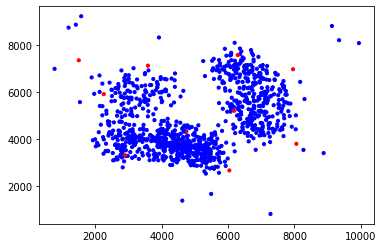

In [305]:
final_answer(10)

### The final answer for $N = 25$:

(4301, 6562)
(4637, 4474)
(6359, 7594)
(4177, 4575)
(7815, 5511)
(4881, 2887)
(6598, 4253)
(1971, 5915)
(3349, 4411)
(7670, 6456)
(3616, 3292)
(5506, 4225)
(8059, 3797)
(4390, 3617)
(5553, 7000)
(9344, 8190)
(2239, 4076)
(7279, 824)
(5332, 2533)
(1579, 9205)
(5982, 5533)
(3440, 5291)
(2326, 3803)
(3589, 7110)
(1507, 7337)


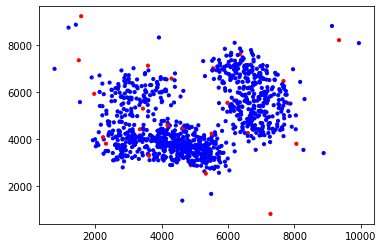

In [306]:
final_answer(25)

### The final answer for $N = 63$:

(2383, 4753)
(7688, 6246)
(4387, 3077)
(5529, 6907)
(2913, 6709)
(6598, 4253)
(3165, 3728)
(5728, 2568)
(5618, 4178)
(6634, 5942)
(6927, 5402)
(3582, 5448)
(6737, 7049)
(9344, 8190)
(1579, 9205)
(4212, 4206)
(5345, 3194)
(7919, 4522)
(2098, 3739)
(4686, 4570)
(3508, 6272)
(3603, 3353)
(4773, 3433)
(2141, 5401)
(3920, 8304)
(7858, 4972)
(6100, 7342)
(4571, 5802)
(2659, 3615)
(2771, 5119)
(7279, 824)
(5982, 5533)
(5910, 6151)
(7120, 6005)
(8878, 3403)
(7497, 6728)
(2761, 4154)
(6654, 4982)
(6755, 7560)
(3574, 3640)
(5494, 1672)
(4985, 3962)
(777, 6976)
(5768, 3008)
(5068, 2867)
(5396, 3421)
(2846, 5511)
(3785, 4800)
(6156, 4610)
(3113, 3200)
(7083, 3782)
(3551, 4381)
(3155, 7001)
(6610, 6452)
(4652, 4081)
(7263, 4680)
(4238, 3717)
(4301, 6562)
(3349, 4411)
(5804, 3706)
(7880, 5502)
(2217, 6350)
(6049, 6731)


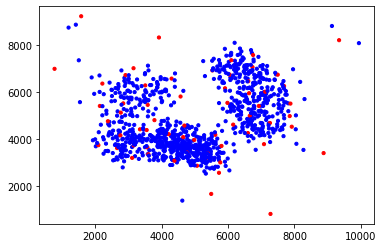

In [307]:
final_answer(63)

### The final answer for $N = 159$:

(5279, 4073)
(5905, 7824)
(2171, 4607)
(6893, 4952)
(3654, 5856)
(3583, 3361)
(7317, 6107)
(4328, 3516)
(1971, 5915)
(5241, 3016)
(7570, 4377)
(6315, 6436)
(2697, 3659)
(9941, 8065)
(1579, 9205)
(3785, 4800)
(6766, 4029)
(3011, 6554)
(6206, 7320)
(6356, 5950)
(3583, 4008)
(7261, 5794)
(5494, 1672)
(3337, 4149)
(5680, 3604)
(2869, 5736)
(4337, 4306)
(6709, 6854)
(5843, 5284)
(4149, 6526)
(5575, 6548)
(7517, 5485)
(5155, 3615)
(2980, 3282)
(4064, 3091)
(2675, 5172)
(5908, 3038)
(1507, 7337)
(4860, 3679)
(2060, 3832)
(7053, 4296)
(4135, 4244)
(7279, 824)
(8878, 3403)
(4842, 3271)
(8173, 6422)
(4375, 5548)
(6718, 7648)
(5704, 6937)
(2731, 4161)
(2434, 6392)
(4133, 3887)
(4134, 6023)
(9129, 8792)
(3589, 7110)
(3920, 8304)
(2141, 5401)
(7157, 6521)
(5369, 3022)
(7099, 5019)
(5728, 2568)
(3440, 5291)
(7178, 7097)
(6291, 5285)
(5920, 6049)
(6371, 4854)
(6049, 6731)
(6686, 7146)
(5928, 4755)
(3457, 4600)
(7533, 5657)
(3398, 6242)
(6919, 5778)
(7858, 4972)
(4321, 2900)
(2821, 3688)
(5046, 4108)


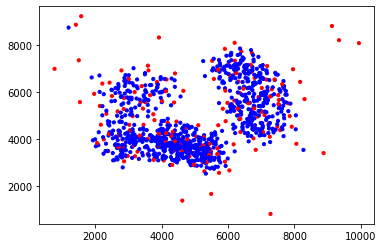

In [308]:
final_answer(159)

### The final answer for $N = 380$:

(6320, 5391)
(2721, 4222)
(5066, 3396)
(2916, 6371)
(6495, 7067)
(3952, 3919)
(7370, 4279)
(4149, 6526)
(7688, 6246)
(9344, 8190)
(5281, 4161)
(3333, 5442)
(1199, 8724)
(6797, 4874)
(5578, 2738)
(6705, 6134)
(3498, 3653)
(4573, 3281)
(3058, 3446)
(2505, 5821)
(7375, 5433)
(5305, 6667)
(4484, 3896)
(4182, 4681)
(3976, 5747)
(7279, 824)
(5951, 7533)
(2217, 6350)
(3899, 3095)
(5752, 3667)
(2921, 4642)
(6438, 4646)
(8271, 3538)
(7073, 6543)
(5832, 6385)
(2098, 3739)
(2340, 5071)
(4169, 3727)
(3920, 8304)
(7341, 4959)
(5205, 3110)
(6919, 4415)
(3240, 4085)
(1507, 7337)
(5355, 3627)
(4687, 3568)
(6934, 5697)
(4954, 4191)
(4624, 1388)
(6066, 5464)
(5742, 6850)
(7858, 4972)
(3606, 6909)
(3988, 4434)
(5483, 3465)
(4131, 3233)
(3516, 6012)
(6472, 7409)
(6833, 3542)
(7695, 5562)
(7047, 7136)
(6114, 6575)
(2530, 3405)
(7120, 6005)
(3127, 4971)
(2797, 5812)
(5821, 4345)
(3751, 5049)
(5068, 2867)
(5722, 3243)
(4284, 4140)
(6302, 6985)
(4682, 4313)
(7692, 4608)
(2757, 3280)
(1542, 5563)
(4134, 6081)


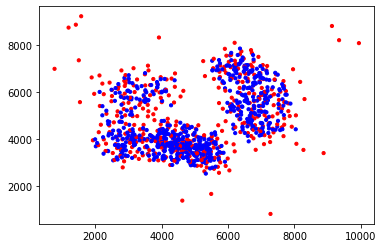

In [309]:
final_answer(380)

### The final answers are listed in the GitHub repo
The $N$ points that best "cover" the shape of the data are listed in the .csv files in the repo. For each $N$, the file "N_$N$_dataframe.csv" lists each of these points. For example, the file "N_10_dataframe.csv" lists the points for $N = 10$.